# Tutorial for bayesian multi-level modeling 
Original tutorial rom https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html

Code was updated in June 2022 to reflect pyMC4 here: https://oriolabrilpla.cat/python/arviz/pymc/xarray/2022/06/07/pymc-arviz.html

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at

rng = np.random.default_rng()

from theano import tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(286)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl
Could not locate executable gfortran
Could not locate executable f95
Could not locate executable g95
Could not locate executable efort
Could not locate executable efc
Could not locate executable flang
don't know how to compile Fortran code on platform 'nt'


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v4.0.1


In [32]:
srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

srrs_mn = (srrs_mn
    .merge(cty_mn[["fips", "Uppm"]], on="fips")
    .drop_duplicates(subset="idnum")
          )
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)
srrs_mn.county = srrs_mn.county.map(str.strip)
srrs_mn["county_code"], mn_counties = pd.factorize(srrs_mn.county)
srrs_mn["log_radon"] = np.log(srrs_mn.activity + 0.1)
log_radon = srrs_mn['log_radon']

1. `level` correspond to basement or first floor
2. `county` each count has:
    - its own basement, intercept, `a`
    - its own first floor, slope effect `b`
3. `param` one of `a, b`
4. `param2` because a variable can't have repeated dimensions for the covariance matrix ... (?????????) 

In [21]:
coords = {
    "level": ["Basement", "Floor"], 
    "County": mn_counties,
    "param": ["a", "b"],
    "param2": ["a", "b"],
}
coords

{'level': ['Basement', 'Floor'],
 'County': Index(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
        'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
        'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
        'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
        'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
        'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
        'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR', 'LINCOLN',
        'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD', 'MEEKER',
        'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET', 'NOBLES',
        'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE', 'PIPESTONE',
        'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE', 'RICE', 'ROCK',
        'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY', 'ST LOUIS', 'STEARNS',
        'STEELE', 'STEVENS', 'SWIFT', 'TODD', 'TRAVERSE', 'WABASHA', 'WADE

### `floor_idx` and `county_dx` are indexing arrays
- They have type `aesara.tensor.var.TensorConstant`

## Varying intercept model

$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i $

Our slope $\beta$ is fixed, but our intercept $\alpha$ can vary by county (note the $j[i]$ subscript)

Errors are distributed as:
$\epsilon_i \sim N(0, \sigma^2_y) $

Intercept has random effect:
$ \alpha_{j[i]} \sim N(\mu_\alpha, \sigma^2_\alpha) $

In [50]:
with pm.Model(coords=coords) as varying_intercept:
    
    floor_idx = pm.ConstantData('floor_idx', srrs_mn['floor'], dims='obs_id')
    county_idx = pm.ConstantData('county_idx', srrs_mn['county_code'], dims='obs_id')
    
    # Hyperpriors:
    # a is α alpha which is our random intercept, we think the mean hyperprior of this is Normally distributed
    a = pm.Normal('a', mu=0, sigma=10)
    # We think the standard deviation hyperprior of alpha is distributed as an Exponential 
    sigma_a = pm.Exponential('sigma_a', 1)
    
    # Vary intercepts: 
    a_county = pm.Normal('a_county', mu=a, 
                         sigma=sigma_a, 
                         dims='County')
    # Common slope: 
    b = pm.Normal('b', mu=0, sigma=10)
    
    # Expectation value θ per county: 
    theta = a_county[county_idx] + b * floor_idx  # a + b*m is similar to y=mx+b
    sigma = pm.Exponential('sigma', 1)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon, dims='obs_id')
# pm.model_to_graphviz(varying_intercept)

In [51]:
with varying_intercept:
    varying_intercept_idata = pm.sample(  # idata = Inference Data
        draws=250, tune=250, init='adapt_diag', random_seed=1, return_inferencedata=True,
        cores=6)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [a, sigma_a, a_county, b, sigma]


Sampling 6 chains for 250 tune and 250 draw iterations (1_500 + 1_500 draws total) took 737 seconds.


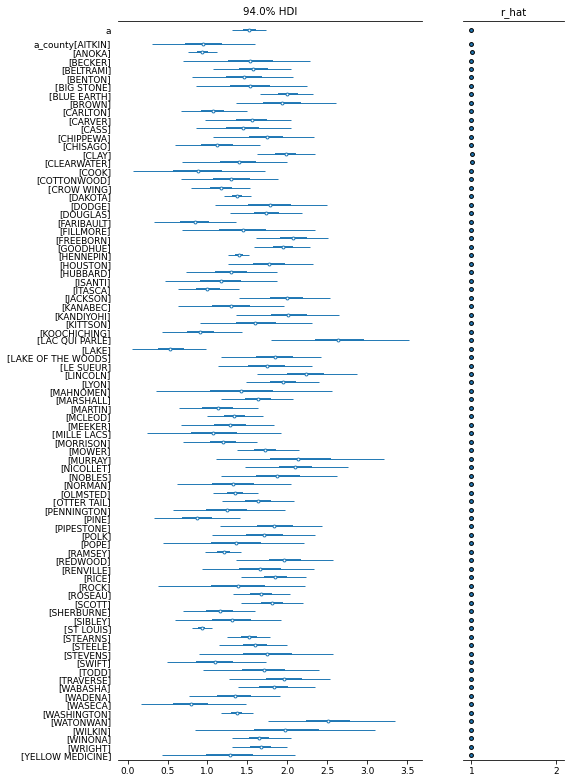

In [43]:
az.plot_forest(
    varying_intercept_idata, var_names=["a", "a_county"], r_hat=True, combined=True, textsize=9);

In [48]:
varying_intercept_idata.keys()

KeysView(Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data)

In [49]:
varying_intercept_idata['posterior']

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 500, County: 85)
Coordinates:
  * chain     (chain) int32 0 1 2 3
  * draw      (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * County    (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
Data variables:
    a         (chain, draw) float64 1.472 1.621 1.461 ... 1.514 1.545 1.376
    a_county  (chain, draw, County) float64 0.6022 1.043 2.609 ... 1.643 1.045
    b         (chain, draw) float64 -0.728 -0.6993 -0.7013 ... -0.6823 -0.6163
    sigma     (chain, draw) float64 0.7416 0.711 0.7368 ... 0.7319 0.7169 0.7263
Attributes:
    created_at:                 2022-07-16T17:46:59.964165
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.0.1
    sampling_time:              961.1797032356262
    tuning_steps:               500

In [44]:
az.plot_trace(varying_intercept_idata, var_names=["a", "sigma_a", "b", "sigma"]);

KeyError: 'var names: "[\'sigma_a\'] are not present" in dataset'

In [51]:
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))
county_lookup

{'AITKIN': 0,
 'ANOKA': 1,
 'BECKER': 2,
 'BELTRAMI': 3,
 'BENTON': 4,
 'BIG STONE': 5,
 'BLUE EARTH': 6,
 'BROWN': 7,
 'CARLTON': 8,
 'CARVER': 9,
 'CASS': 10,
 'CHIPPEWA': 11,
 'CHISAGO': 12,
 'CLAY': 13,
 'CLEARWATER': 14,
 'COOK': 15,
 'COTTONWOOD': 16,
 'CROW WING': 17,
 'DAKOTA': 18,
 'DODGE': 19,
 'DOUGLAS': 20,
 'FARIBAULT': 21,
 'FILLMORE': 22,
 'FREEBORN': 23,
 'GOODHUE': 24,
 'HENNEPIN': 25,
 'HOUSTON': 26,
 'HUBBARD': 27,
 'ISANTI': 28,
 'ITASCA': 29,
 'JACKSON': 30,
 'KANABEC': 31,
 'KANDIYOHI': 32,
 'KITTSON': 33,
 'KOOCHICHING': 34,
 'LAC QUI PARLE': 35,
 'LAKE': 36,
 'LAKE OF THE WOODS': 37,
 'LE SUEUR': 38,
 'LINCOLN': 39,
 'LYON': 40,
 'MAHNOMEN': 41,
 'MARSHALL': 42,
 'MARTIN': 43,
 'MCLEOD': 44,
 'MEEKER': 45,
 'MILLE LACS': 46,
 'MORRISON': 47,
 'MOWER': 48,
 'MURRAY': 49,
 'NICOLLET': 50,
 'NOBLES': 51,
 'NORMAN': 52,
 'OLMSTED': 53,
 'OTTER TAIL': 54,
 'PENNINGTON': 55,
 'PINE': 56,
 'PIPESTONE': 57,
 'POLK': 58,
 'POPE': 59,
 'RAMSEY': 60,
 'REDWOOD': 61,
 'RENV

In [55]:
srrs_mn#.columns

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081,MN,MN,27,55735,5,1,1,3,N,...,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054,0,0.832909
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,14.5,471.366223,0,0,1,AITKIN,27001,0.502054,0,0.832909
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,9.6,433.316718,0,0,1,AITKIN,27001,0.502054,0,1.098612
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,24.3,461.623670,0,0,1,AITKIN,27001,0.502054,0,0.095310
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13.8,433.316718,0,0,3,ANOKA,27003,0.428565,1,1.163151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,5995,MN,MN,27,55363,5,1,0,4,Y,...,4.5,1146.499190,0,0,171,WRIGHT,27171,0.913909,83,1.871802
923,5996,MN,MN,27,55376,5,1,0,7,Y,...,8.3,1105.956867,0,0,171,WRIGHT,27171,0.913909,83,1.526056
924,5997,MN,MN,27,55376,5,1,0,4,Y,...,5.2,1214.922779,0,0,171,WRIGHT,27171,0.913909,83,1.629241
925,5998,MN,MN,27,56297,5,1,0,4,Y,...,9.6,1177.377355,0,0,173,YELLOW MEDICINE,27173,1.426590,84,1.335001


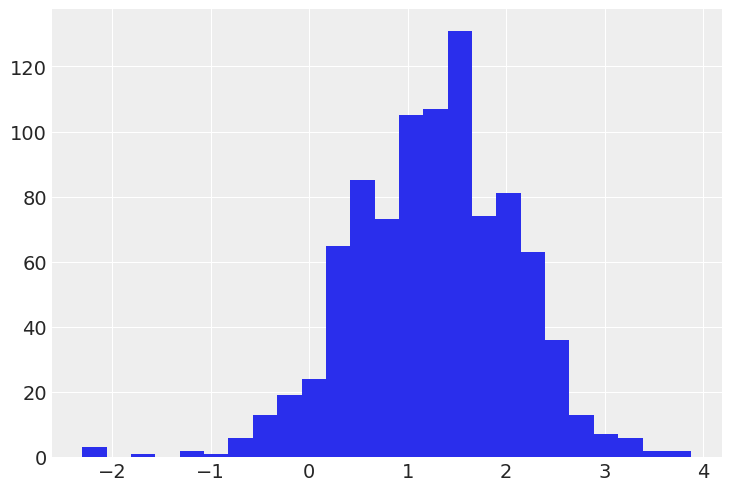

In [52]:
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

srrs_mn.log_radon.hist(bins=25);

# Complete pooling model
## One model for all MN counties

In [56]:
coords = {"Level": ["Basement", "Floor"], "obs_id": np.arange(floor.size)}
with pm.Model()

{'Level': ['Basement', 'Floor'],
 'obs_id': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        

# Tutorial walks through bayesian modeling with pyMC3

from https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

In [26]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

print('Running on PyMC3 v{}'.format(pm.__version__))
data = pd.read_csv('C:/Users/bjanderson23/downloads/renfe.csv')
# data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac=0.04, random_state=99)
data.head(3)

Running on PyMC3 v3.11.5


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
4738,2019-04-17 08:03:35,VALENCIA,MADRID,2019-05-21 08:00:00,2019-05-21 09:47:00,AVE,33.65,Turista,Promo
8722,2019-05-09 07:12:41,MADRID,BARCELONA,2019-05-25 08:30:00,2019-05-25 11:15:00,AVE,85.10,Turista,Promo
13185,2019-04-24 11:21:26,MADRID,VALENCIA,2019-05-22 17:40:00,2019-05-22 19:20:00,AVE,51.15,Turista,Promo


In [27]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.120155
train_class    0.004845
fare           0.004845
dtype: float64

## Impute missing values

In [28]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

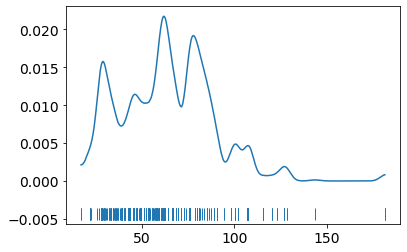

In [29]:
az.plot_kde(data['price'].values, rug=True)  # The data points underneath are 

# Perform Gaussian inference on ticket price data

## Choose priors $\mu, \sigma$
- $\mu$ is population mean
    - It is unknown so set the boundaries of the distribution to be between, say 0 and 300 (max ticket price in sample is 220)
    - We use the Uniform distribution, not the Normal distribution, for the prior of this parameter
    
- $\sigma$ can only be positive, so use the `HalfNormal` distribution 

## Choose likelihood function for `y`
- Ticket price is a distribution that we assume comes from a normal distribution with params $\mu, \sigma$
    - Draw 1000 posterior samples using NUTS sampling 

In [30]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=0, upper=300)
    sigma = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sigma, observed=data['price'].values)
    trace_g = pm.sample(draws=10, tune=10, chains=2, cores=7)

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 907 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

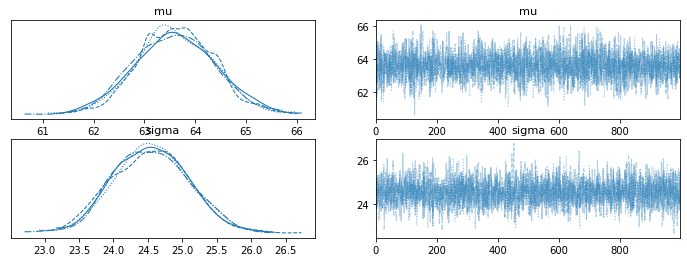

In [31]:
az.plot_trace(trace_g)